## Two Groups with Binary Outcome

Now that we have seen how to generalize normally-distributed data to another distribution, we are equipped to analyze other data types. Binary outcomes are common in clinical research: 

- survival/death
- true/false
- presence/absence
- positive/negative

> *Never, ever dichotomize continuous or ordinal variables prior to statistical analysis*

In practice, binary outcomes are encoded as ones (for event occurrences) and zeros (for non-occurrence). A single binary variable is distributed as a **Bernoulli** random variable:

$$f(x \mid p) = p^{x} (1-p)^{1-x}$$

Such events are sometimes reported as sums of individual events, such as the number of individuals in a group who test positive for a condition of interest. Sums of Bernoulli events are distributed as **binomial** random variables.

$$f(x \mid n, p) = \binom{n}{x} p^x (1-p)^{n-x}$$

The parameter in both models is $p$, the probability of the occurrence of an event. In terms of inference, we are typically interested in whether $p$ is larger or smaller in one group relative to another.

To demonstrate the comparison of two groups with binary outcomes using Bayesian inference, we will use a sample pediatric dataset. Data on 671 infants with very low (<1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center. Of interest is the relationship between the outcome intra-ventricular hemorrhage (IVH) and predictor such as birth weight, gestational age, presence of pneumothorax and mode of delivery.

![](images/ivh.gif)

In [44]:
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


To demonstrate binary data analysis, we will try to estimate the difference between the probability of an intra-ventricular hemorrhage for infants with a pneumothorax. 

In [45]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


We will create a binary outcome by combining `definite` and `possible` into a single outcome.

In [46]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

### Prior choice

What should we choose as a prior distribution for $p$?

We could stick with a normal distribution, but note that the value of $p$ is **constrained** by the laws of probability. Namely, we cannot have values smaller than zero nor larger than one. So, choosing a normal distribution will result in ascribing positive probability to unsupported values of the parameter. In many cases, this will still work in practice, but will be inefficient for calculating the posterior and will not accurately represent the prior information about the parameter.

A common choice in this context is the **beta distribution**, a continuous distribution with 2 parameters and whose support is on the unit interval:

$$ f(x \mid \alpha, \beta) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}$$

- Support: $x \in (0, 1)$
- Mean: $\dfrac{\alpha}{\alpha + \beta}$
- Variance: $\dfrac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$

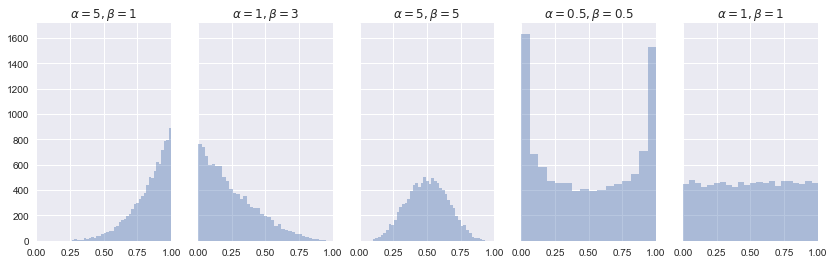

In [47]:
from pymc3 import Beta

params = (5, 1), (1, 3), (5, 5), (0.5, 0.5), (1, 1)

fig, axes = plt.subplots(1, len(params), figsize=(14, 4), sharey=True)
for ax, (alpha, beta) in zip(axes, params):
    sns.distplot(Beta.dist(alpha, beta).random(size=10000), ax=ax, kde=False)
    ax.set_xlim(0, 1)
    ax.set_title(r'$\alpha={0}, \beta={1}$'.format(alpha, beta));

So let's use a beta distribution to model our prior knowledge of the probabilities for both groups. Setting $\alpha = \beta = 1$ will result in a uniform distribution of prior mass:

In [48]:
with Model() as ivh_model:
    
    p = Beta('p', 1, 1, shape=2)

We can now use `p` as the parameter of our Bernoulli likelihood. Here, `x` is a vector of zeros an ones, which will extract the approproate group probability for each subject:

In [49]:
from pymc3 import Bernoulli

with ivh_model:
    
    bb_like = Bernoulli('bb_like', p=p[x], observed=ivh)

Finally, since we are interested in the difference between the probabilities, we will keep track of this difference:

In [50]:
with ivh_model:
    
    p_diff = Deterministic('p_diff', p[1] - p[0])

In [51]:
with ivh_model:
    ivh_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 226.28: 100%|██████████| 10000/10000 [00:00<00:00, 13352.85it/s]
Finished [100%]: Average Loss = 226.28


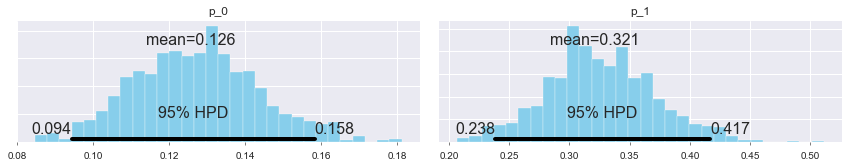

In [52]:
plot_posterior(ivh_trace[100:], varnames=['p'], color='#87ceeb');

We can see that the probability that `p` is larger for the pneumothorax with probability one.

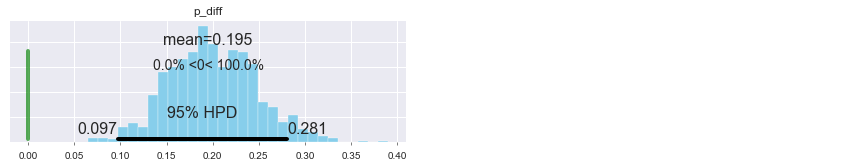

In [53]:
plot_posterior(ivh_trace[100:], varnames=['p_diff'], ref_val=0, color='#87ceeb');

As a final demonstration, let's make this analysis slightly more realistic. Since these are observational data, its probably a bad idea to compare group probabilities without correcting them for **confounding variables**. Individuals may have systematic differences between groups that may explain the difference in observed outcomes that have nothing to do with group membership itself. 

For example, perhaps lower birthweight accounts for the difference, since birthweight is nominally lower in the pneumothorax group:

In [ ]:
vlbw.groupby('pneumo').bwt.mean()

Let's add birth weight as a predictor to our model (but first we will standardize it to aid interpretation and for numerical stability):

In [ ]:
bwt_norm = (vlbw.bwt - vlbw.bwt.mean()) / vlbw.bwt.std()

How do we add a continuous covariate to this model?

The easiest way to do so is to change the formulation of the model to that of a **generalized linear model (GLM)**. What this does is create a regression model to predict the latent probability of IVH for each individual. 

$$p_i = \mu + \alpha * \text{bwt}_i + \beta * \text{pneumo}_i$$

here, $\mu$ is a baseline probability, $\alpha$ is a coefficient for centered birthweight, and $\beta$ is a coefficient for pneumothorax.

However, this presents a problem as formulated: its very easy to generate combinations of $\mu$, $\alpha$, and $\beta$ that generate values outside the $(0,1)$ interval. To avoid this, we must **transform** this sum in such a way that the unit interval constraint is guaranteed.

One such transformation is the **logit**:

$$x = \text{logit}(p) = \log\left[\frac{p}{1-p}\right]$$

the inverse of this function maps real values of $x$ to values of $p$ on the unit interval:

$$p = \text{invlogit}(x) = \frac{1}{1 + \exp(-x)}$$

In [ ]:
x_range = np.linspace(-7,7)
plt.plot(x_range, 1/(1+np.exp(-x_range)))
plt.xlabel('x')
plt.ylabel('p');

To convert our original model to a GLM, we need to specify priors for the linear model coefficients:

In [ ]:
with Model() as ivh_glm:
    
    μ = Normal('μ', 0, sd=5)
    α = Normal('α', 0, sd=5)
    β = Normal('β', 0, sd=5)

Then, apply the `invlogit` transformation to the linear combination of predictors.

The likelihood stays the same.

In [ ]:
from pymc3.math import invlogit

with ivh_glm:
        
    p = invlogit(μ + α*bwt_norm + β*x)
    
    bb_like = Bernoulli('bb_like', p=p, observed=ivh)
    
with ivh_glm:
    trace_glm = sample(1000, chains=2)

We can see that the estimate for $\alpha$ is negative, indicating that higher birth weight reduces the baseline probability of IVH. 

The coefficient for $\beta$ is strongly positive.

In [ ]:
plot_posterior(trace_glm[100:], var_names=['μ', 'α', 'β']);

# How might we represent the effect of pneumothorax as a quantity on the probability scale, to aid interpretation?

## References and Resources

- Goodman, S. N. (1999). Toward evidence-based medical statistics. 1: The P value fallacy. Annals of Internal Medicine, 130(12), 995–1004. http://doi.org/10.7326/0003-4819-130-12-199906150-00008
- Johnson, D. (1999). The insignificance of statistical significance testing. Journal of Wildlife Management, 63(3), 763–772.
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian Data Analysis, Third Edition. CRC Press.
- Kruschke, J.K. *Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan.* 2015. Academic Press / Elsevier. 
- O'Shea M, Savitz D.A., Hage M.L., Feinstein K.A.: *Prenatal events and the risk of subependymal / intraventricular haemorrhage in very low birth weight neonates*. **Paediatric and Perinatal Epdiemiology** 1992;6:352-362